# CIFAR10 - 3

In [1]:
# 0) import our needed libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import requests
from PIL import Image
from torchvision import datasets, transforms

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [4]:
# 1) load the dataset
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                      transforms.Resize((32, 32)),
#                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                                      transforms.RandomRotation(10),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
#                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
#                                      ])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32, 32))])
training_data = datasets.CIFAR10(root='./data',
                                 train=True, 
                                 download=True,
                                 transform=transform
                                 )
training_loader = torch.utils.data.DataLoader(training_data,
                                              batch_size=100, 
                                              shuffle=True
                                              )
validation_data = datasets.CIFAR10(root='./data', 
                                 train=False,
                                 download=True,
                                 transform=transform
                                 )
validation_loader = torch.utils.data.DataLoader(validation_data,
                                                batch_size=100,
                                                shuffle=False
                                                )
print(training_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
           )


In [5]:
# 2) visualize the dataset
data_iter = iter(training_loader)
images, labels = next(data_iter)
classes = training_loader.dataset.classes
print(images.shape)

torch.Size([100, 3, 32, 32])


In [6]:
def image_converter(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    return image

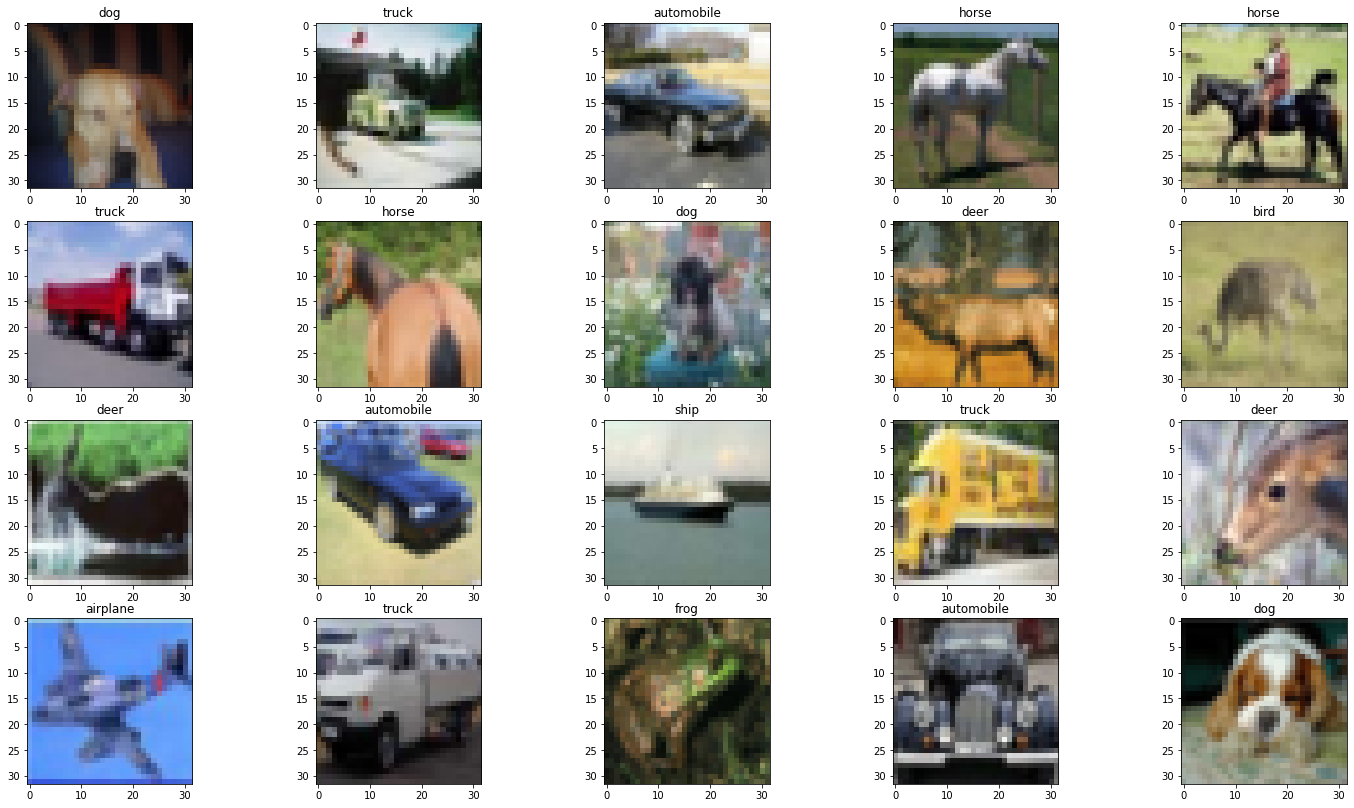

In [7]:
fig = plt.figure(figsize=(25, 14))
for idx in range(20):
    ax = fig.add_subplot(4, 5, idx+1)
    plt.imshow(image_converter(images[idx]))
    ax.set_title(classes[labels[idx]])

In [8]:
# 3) Build our model 
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, (3, 3), 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, (3, 3), 1, padding=1)
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 4) Train our model 

epochs = 16
training_loss = []
training_acc = []
validation_loss = []
validation_acc = []
for e in range(epochs):
    losses = 0.0
    accuracies = 0.0
    for images, labels in training_loader: 
        inputs = images.to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs.cpu(), labels)
        
        losses += loss.item()
        _, max_index = torch.max(outputs, 1)
        accuracies += torch.sum(max_index.cpu() == labels.cpu()) / labels.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    else: 
        epoch_loss = losses / len(training_loader)
        training_loss.append(epoch_loss)
        epoch_acc = accuracies / len(training_loader)
        training_acc.append(epoch_acc)
        
        with torch.no_grad():
            losses = 0.0
            accuracies = 0.0
            for images, labels in validation_loader:
                inputs = images.to(device)
                outputs = model(inputs).to(device)
                loss = criterion(outputs.cpu(), labels)
                
                losses += loss.item()
                _, max_index = torch.max(outputs, 1)
                accuracies += torch.sum(max_index.cpu() == labels.cpu()) / labels.shape[0]
                
            validation_epoch_loss = losses / len(validation_loader)
            validation_loss.append(validation_epoch_loss)
            validation_epoch_acc = accuracies / len(validation_loader)
            validation_acc.append(validation_epoch_acc)
            
        print("epoch :{}, T_acc={:.4f}, T_loss={:.4f} || V_acc={:.4f}, V_loss={:.4f}".format(e, 
                                                                                             epoch_acc,
                                                                                             epoch_loss,
                                                                                             validation_epoch_acc,
                                                                                             validation_epoch_loss
                                                                                             ))
        

epoch :0, T_acc=0.3506, T_loss=1.7539 || V_acc=0.4509, V_loss=1.5177
epoch :1, T_acc=0.4770, T_loss=1.4420 || V_acc=0.4931, V_loss=1.4118
epoch :2, T_acc=0.5347, T_loss=1.2953 || V_acc=0.5559, V_loss=1.2364
epoch :3, T_acc=0.5744, T_loss=1.1981 || V_acc=0.5846, V_loss=1.1675
epoch :4, T_acc=0.6014, T_loss=1.1160 || V_acc=0.6006, V_loss=1.1311
epoch :5, T_acc=0.6284, T_loss=1.0497 || V_acc=0.6304, V_loss=1.0641
epoch :6, T_acc=0.6528, T_loss=0.9828 || V_acc=0.6460, V_loss=1.0128
epoch :7, T_acc=0.6683, T_loss=0.9416 || V_acc=0.6546, V_loss=0.9832
epoch :8, T_acc=0.6855, T_loss=0.8928 || V_acc=0.6588, V_loss=0.9951
epoch :9, T_acc=0.6944, T_loss=0.8707 || V_acc=0.6607, V_loss=0.9839
epoch :10, T_acc=0.7096, T_loss=0.8260 || V_acc=0.6742, V_loss=0.9538
epoch :11, T_acc=0.7193, T_loss=0.7970 || V_acc=0.6720, V_loss=0.9681
epoch :12, T_acc=0.7245, T_loss=0.7763 || V_acc=0.6852, V_loss=0.9360
epoch :13, T_acc=0.7371, T_loss=0.7418 || V_acc=0.6860, V_loss=0.9239
epoch :14, T_acc=0.7465, T_los

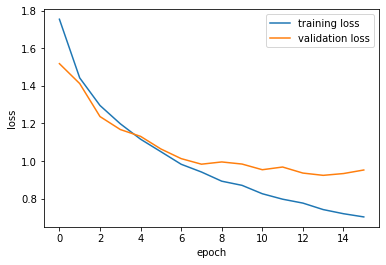

In [11]:
# 5) plot loss and accuracy curves
plt.plot(range(epochs), training_loss, label='training loss')
plt.plot(range(epochs), validation_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

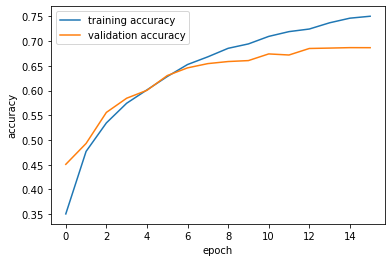

In [12]:
plt.plot(range(epochs), training_acc, label='training accuracy')
plt.plot(range(epochs), validation_acc, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

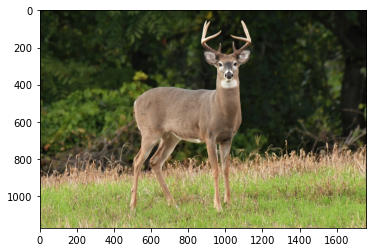

In [22]:
# 6) Check our model 
url = 'https://npr.brightspotcdn.com/dims4/default/78baf45/2147483647/strip/true/crop/3392x2260+0+0/resize/1760x1172!/format/webp/quality/90/?url=http%3A%2F%2Fnpr-brightspot.s3.amazonaws.com%2F06%2F1f%2F5b5e2ff84138b0e41c10a963c0f4%2Fwhitetailbuck.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

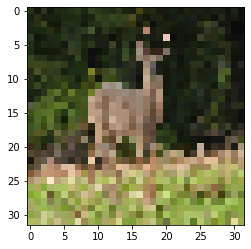

In [23]:
img = transform(img)
plt.imshow(image_converter(img))

In [25]:
my_img = img.to(device)
output = model(my_img)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


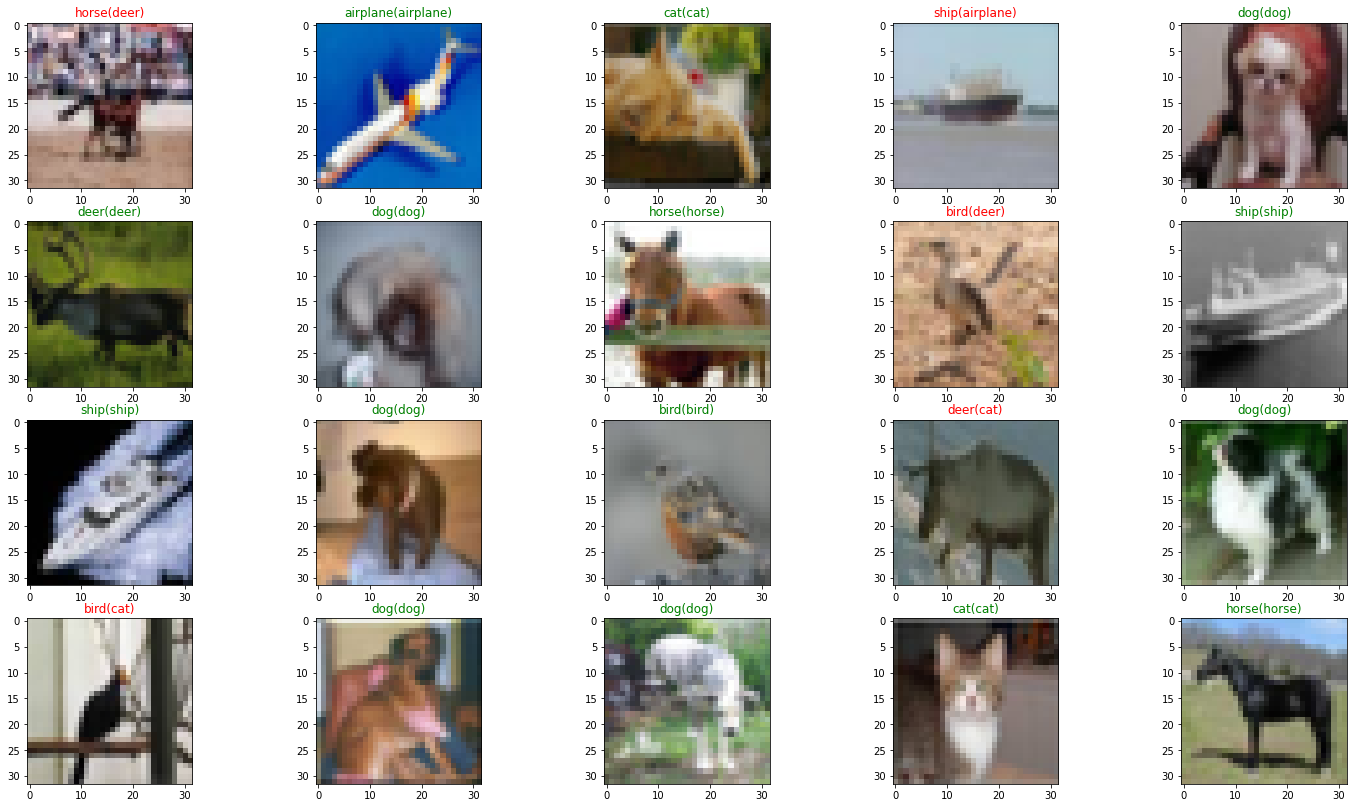

In [27]:
# 7) Testing our model
# data_iter = iter(validation_loader)
images, labels = next(data_iter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(25, 14))
for idx in range(20): 
    ax = fig.add_subplot(4, 5, idx+1)
    plt.imshow(image_converter(images[idx]))
    ax.set_title("{}({})".format(classes[labels[idx]], classes[preds[idx]]),
                 color='green' if labels[idx]==preds[idx] else 'red')